# <p style="padding:10px;background-color:#980000;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 50px 50px;overflow:hidden;font-weight:500">Object Detection</p>

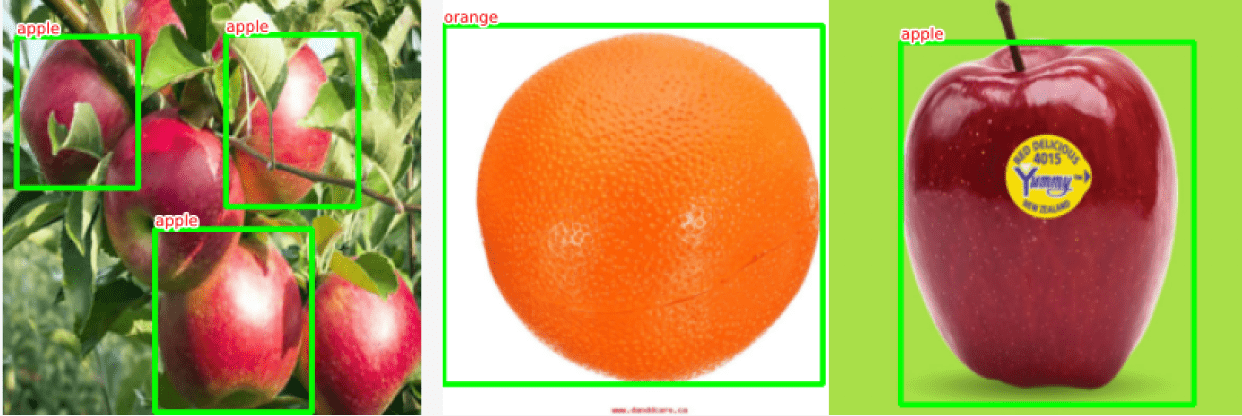

<hr/>
Object detection is a computer vision and image processing related technique that deals with detecting instances of semantic objects in an image or video. Unlike image classification where labeling object is sufficient object detection involves identifying the position and the boundaries of an object, and only then classifying it into the corresponding categories.

<hr/>
<b>Dataset:</b> In this project we are dealing with fruit images dataset. The dataset include the pictures of fruits as well as the `.xml` files that among other things describe the ground truth bounding box coordinates around the objects.
<br/>
<b>The main question of the project is:</b> Given the training images with ground truth bounding boxes can we detect fruits in unseen images?

<b>Methods and Findings:</b> We are leveraging an object detection model known as Faster R-CNN to detect our fruits. In order to be able to utilize the model we are creating a dataset class to capture the images and preprocess them. The results are fed into the model.

1. Create a dataset class to read and preprocess the data.

2. Define our model with corresponding attributes.

3. Track the model's performance.

In [1]:
!pip install -q torch_snippets lovely-tensors torchinfo

from torch_snippets import *
from IPython import display 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
display.set_matplotlib_formats('svg')

from torchinfo import summary

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  import sys


# Reading the Data 📖

The data is not big. It contains $240$ images of fruits in the train folder and $60$ images in the test folder.  
At this part of the project we will:
- retrieve the images
- resize them
- retrieve the objects labels for each image
- retrieve the ground truth bounding boxes of the objects for each image
- resize them accordingly


In [2]:
root = '/kaggle/input/fruit-images-for-object-detection/train_zip/train/'

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [3]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target: 
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()

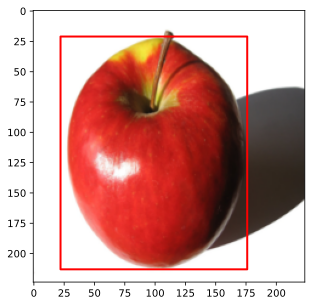

In [4]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), 
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

val_root = '/kaggle/input/fruit-images-for-object-detection/test_zip/test/'
    
train_ds = FruitsDataset()
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)

val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = train_ds[10]
plot_img_bbox(img.permute(1,2,0), target['boxes'])

# Model evaluation 🤖

Let's try to understand the core phases of the prediction process our model is using:
1. Anchor Boxes:
These serve as a replacement of the selective search based region proposals.
- <b>Key Idea</b> Typically the majority of the objects have a similar shape e.g. a ground truth bounding box for a person will have a greater height than width.
 - The inspection of the ground truth bounding boxes of the objects present in the images helps to build a descent idea about the height and the width of the objects.
 - Albeit, some images can be scaled. This will result in the the distortion of the object's height and width. Hence, an aspect ration $\frac{\text{height}}{\text{width}}$ is computed from the ground truth values for objects of each class.
 - After completion of the previous two steps we can define the <span style="background-color: green;">anchor boxes</span> with heights and widths representing the majority of objects' bounding boxes within certain class for our dataset.
 
At this stage we have the anchor boxes of certain height/width for each class of objects. However, how one can use such boxes to detect the objects of those classes in the images?  
The answer is by sliding:
- Slide each anchor box over an image from top left to bottom right.

2. Region Proposal Network (RPN)
We pass the image's crops identified by anchor boxes to the RPN model. It then suggests the likelihood of the crop containing an object.
- For each possible crop compute the IoU$^*$. Those boxes that have higher IoU then some threshold will get a label that mentions that they contain an object. Others will be labeled $0$.
All the candidate crops that have small IoU will be discarded while training.

Finally, we can perform non-max supression (since multiple crops can contain the same object) to identify the region candidate that has the highest probability of containing an object and eliminate other region candidates that have a high overlap with it.

At this point we managed to build up bounding boxes that are likely to contain the objects. Are we done? Not yet. We should also predict what kind the class of the object around which the bounding box has been created.

3. Classification and Regression
Here we are using something known as RoI pooling layer and pass both the image featured learned from the CNN as well as the candidate bounding boxes to RoI.  
RoI pooling is needed to convert each feature map into a fixed dimension map that onward would be passed to fully connected network (FCN). The conversion goes like this:  
 3.1. Take the feature map and the candidate bounding box (i.e. region proposal).  
 3.2. Divide the candidate bounding box into equal-sized sections. The number of this sections is the same as the dimension of the output.  
 3.3 Do max-pooling for these sections.

So, RoI lets us to form feature maps of fixed size from a list of candidate bounding boxes of different size.
The remaining is straightforward:
- Flatten the RoI outputs pass to FCN that predicts:

a) The class of the object.

b) The amount of offset for the candidate bounding box to maximize the IoU with the ground truth.

$^*$Remark: Intersection over Union (IoU) is a measure of accuracy i.e. how overlapping the predicted and actual bounding boxes are
$$ IoU = \frac{\text{Area of overlapping region}}{\text{Area of combined region}} $$



<hr/>
All of this is done behind the scenes. Here we are not going to train the model from scratch and go through all those phases (partly because we don't possess the computational resources to do so). Hence, we will use an already pretrained mode from pytorch library.

In [5]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# test the model
imgs, targets = next(iter(train_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
print(model(imgs, targets))
summary(model, (1,3,224,224))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

{
    'loss_classifier': tensor grad NllLossBackward0 cuda:0 1.882,
    'loss_box_reg': tensor grad DivBackward0 cuda:0 0.253,
    'loss_objectness': tensor grad BinaryCrossEntropyWithLogitsBackward0 cuda:0 0.001,
    'loss_rpn_box_reg': tensor grad DivBackward0 cuda:0 0.005
}

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

EPOCH: 0.017  trn_loss: 1.993  trn_loc_loss: 1.661  trn_regr_loss: 0.325  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.004  (0.84s - 250.20s remaining)
EPOCH: 0.033  trn_loss: 1.067  trn_loc_loss: 0.554  trn_regr_loss: 0.489  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.015  (1.35s - 200.47s remaining)
EPOCH: 0.050  trn_loss: 0.623  trn_loc_loss: 0.321  trn_regr_loss: 0.289  trn_loss_objectness: 0.007  trn_loss_rpn_box_reg: 0.005  (1.88s - 185.98s remaining)
EPOCH: 0.067  trn_loss: 0.582  trn_loc_loss: 0.281  trn_regr_loss: 0.288  trn_loss_objectness: 0.004  trn_loss_rpn_box_reg: 0.009  (2.48s - 183.64s remaining)


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 0.083  trn_loss: 0.638  trn_loc_loss: 0.349  trn_regr_loss: 0.279  trn_loss_objectness: 0.001  trn_loss_rpn_box_reg: 0.009  (2.99s - 176.18s remaining)
EPOCH: 0.100  trn_loss: 0.490  trn_loc_loss: 0.298  trn_regr_loss: 0.190  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.002  (3.48s - 170.66s remaining)
EPOCH: 0.117  trn_loss: 0.625  trn_loc_loss: 0.314  trn_regr_loss: 0.301  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.006  (4.05s - 169.49s remaining)
EPOCH: 0.133  trn_loss: 0.426  trn_loc_loss: 0.204  trn_regr_loss: 0.199  trn_loss_objectness: 0.017  trn_loss_rpn_box_reg: 0.006  (4.54s - 165.66s remaining)
EPOCH: 0.150  trn_loss: 0.325  trn_loc_loss: 0.149  trn_regr_loss: 0.163  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.004  (5.08s - 164.20s remaining)
EPOCH: 0.167  trn_loss: 0.284  trn_loc_loss: 0.118  trn_regr_loss: 0.158  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.002  (5.56s - 161.31s remaining)
EPOCH: 0.183  trn_loss: 0.388  trn_loc_loss: 0

100%|██████████| 106/106 [00:00<00:00, 5477.82it/s]


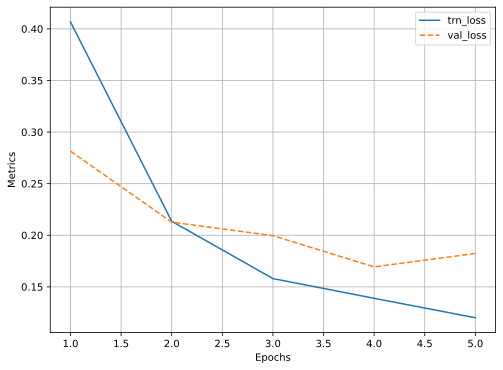

In [6]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs = 5
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(train_dl):
        N = len(train_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)
log.plot_epochs(['trn_loss', 'val_loss'])

# Model Testing ⚡

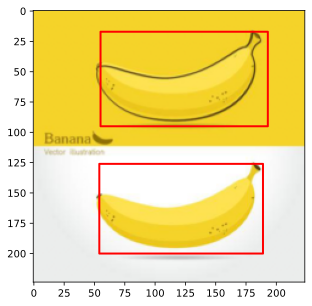

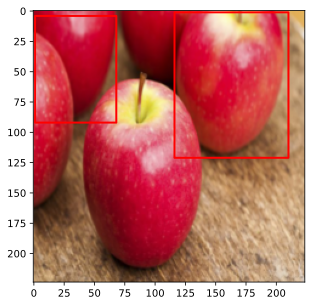

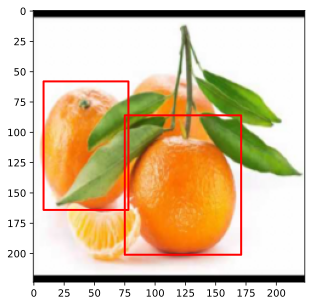

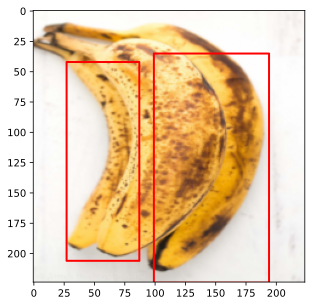

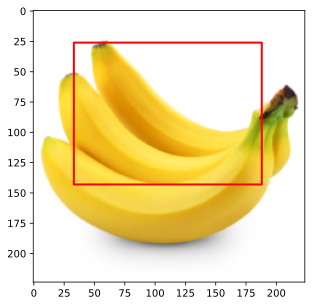

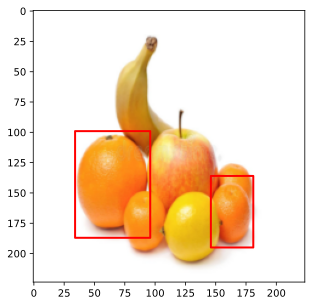

In [7]:


from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    imgs = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    if i == 3: break
    images = [im for im in imgs]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        plot_img_bbox(images[i].cpu().permute(1,2,0), bbs)

